In [1]:
import torch
import torchvision

batch_size_train = 64
batch_size_test = 1000

# copied from some random place to load MNIST data
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

In [2]:
%%time
# filter out 4, 9 data points and form train/test set
test_raw = [
    (data[i][0].numpy(), targets[i].numpy())
    for data, targets in test_loader
    for i in range(data.shape[0])
    if targets[i] in [4, 9]
]
train_raw = [
    (data[i][0].numpy(), targets[i].numpy())
    for data, targets in train_loader
    for i in range(data.shape[0])
    if targets[i] in [4, 9]
]

CPU times: user 11.9 s, sys: 86.7 ms, total: 12 s
Wall time: 12 s


In [3]:
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# preprocess training data into batch
train_x = [
    x.reshape((batch_size_train, 28*28))  # reshape to flat
    for x in [
        np.array([x for x, _ in train_raw[i:i+batch_size_train]])
        for i in range(0, len(train_raw), batch_size_train)
    ][:-1]  # drop last bit of data points 
]
train_y = [
    np.array([y for _, y in train_raw[i:i+batch_size_train]])
    for i in range(0, len(train_raw), batch_size_train)
][:-1]

# one hot encoding for training ground truth
train_y_1hot = [np.zeros((batch_size_train, 2)) for _ in train_y]
for i, y in enumerate(train_y):
    train_y_1hot[i][np.arange(batch_size_train),(y==9).astype('int')] = 1

In [5]:
# preprocess test set to get accuracy
test_x = np.array([x for x, _ in test_raw]).reshape((len(test_raw), 28*28))
test_y = np.array([1 if y == 4 else 0 for _, y in test_raw])

def get_accuracy(model):
    result = model.inference(test_x.transpose())
    # this is some crazy shit ...
    return ((result[0] > result[1]).astype(int) == test_y).sum() / float(len(test_y))

In [6]:
from src.model import Model
from src.cost import LogSoftmax
from src.activation import Identity

In [12]:
# build model
m = Model(learning_rate=.12, cost=LogSoftmax).layer(28*28).layer(20).layer(20).layer(2, Identity)

In [13]:
# repeating data set (because I don't have enough)
xx = train_x*10
yy = train_y_1hot*10

# collect cost and accuracy for plotting
cost, accuracy = [], []

In [14]:
%%time
# train
for i in range(len(xx)):
    x, y = xx[i].transpose(), yy[i].transpose()
    m.inference(x)
    cost.append(m.get_cost(y))
    m.back_prop(y)
    accuracy.append(get_accuracy(m))

CPU times: user 37.9 s, sys: 13.2 s, total: 51.1 s
Wall time: 25.9 s


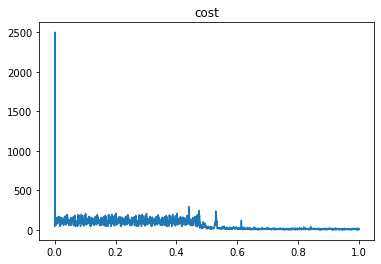

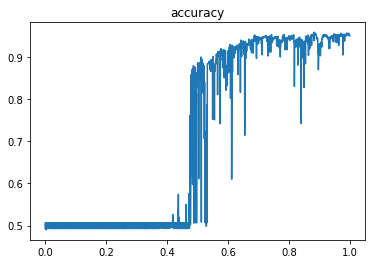

In [15]:
# plot cost and accuracy
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,len(cost)), np.array(cost))
ax.set_title('cost')
plt.show()
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,len(accuracy)), np.array(accuracy))
ax.set_title('accuracy')
plt.show()

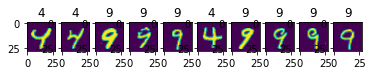

In [16]:
# randomly pick some test data points to give some intuitive proof
n = 10
random_pick = test_x[np.random.choice(np.arange(test_x.shape[0]), n)]
result = m.inference(random_pick.transpose())
fig, axs = plt.subplots(1, n)
for i in range(n):
    # use prediction as title
    axs[i].set_title('{}'.format(4 if result[0][i] > result[1][i] else 9))
    axs[i].imshow(random_pick[i].reshape((28, 28)))
plt.show()